# Preprocessing asthma data
## Work in progress

The childhood asthma data comes from the [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/childhood-asthma-healthcare-utilization) (WPRDC) and covers Allegheny County for the year 2017. The data consist of counts of asthma related healthcare encounters over the entire year, as well as the overall number of children, localized by census tract.

The raw data has columns
- `Census_tract`: str identifier of census tract
- `Total_members`: number of children who could have been observed having an asthma-related medical encounter in this dataset
- `Asthma_use`: int count of number of children who had at least one asthma-related medical encounter from the set
    - emergency department visit
    - acute inpatient encounter
    - outpatient visit or observational stay
    - asthma controller medication dispensing event
- `UC_visits`: int count of number of children who had at least one asthma-related urgent care visit
- `ED_visits`: int count of number of children who had at least one asthma-related emergency department visit
- `ED_hosp`: int count of number of children who had at least one asthma-related emergency department hospitalizations

Before attempting to use the asthma data as a dependent variable, I want to examine the data, compute variables, examine missingness, and check for outliers.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd

from air_brain.config import data_dir

## Import and basic pre-processing

In [2]:
# import the childhood asthma healthcare utilization data
asthma_raw = pd.read_csv(data_dir / "asthma.csv")

# import the census tracts in Allegheny County, so we can check for missing data
tracts = gpd.read_file(data_dir / "tract_2010" / "tl_2010_42003_tract10.shp")
tracts.GEOID10 = tracts.GEOID10.astype(int)

# merge
asthma = tracts.merge(asthma_raw, left_on="GEOID10", right_on="Census_tract", how="outer", validate="1:1")

In [3]:
# where data is missing, fill in with 0 for now
# these are areas where Total_members was 0, so this fill is accurate
#
# missing data marked by Census_tract being NaN
print("Filling in {} cases of missing data with 0s".format(len(asthma.loc[asthma.Total_members.isna()])))
asthma.fillna({"Total_members": 0, "Asthma_use": 0, "UC_visits": 0, "ED_visits": 0, "ED_hosp": 0}, inplace=True)

Filling in 4 cases of missing data with 0s


In [4]:
# check that counts make sense

# every encounter type has at most Total_members
assert(len(asthma.loc[asthma.Total_members < asthma.Asthma_use]) == 0)
assert(len(asthma.loc[asthma.Total_members < asthma.UC_visits]) == 0)
assert(len(asthma.loc[asthma.Total_members < asthma.ED_visits]) == 0)
assert(len(asthma.loc[asthma.Total_members < asthma.ED_hosp]) == 0)

# every specific encounter type has at most Asthma_use
assert(len(asthma.loc[asthma.Asthma_use < asthma.UC_visits]) == 0)
assert(len(asthma.loc[asthma.Asthma_use < asthma.ED_visits]) == 0)
assert(len(asthma.loc[asthma.Asthma_use < asthma.ED_hosp]) == 0)

# ED hospitalizations should be a subset of ED visits
# so if ED_visits < ED_hosp, set ED_visits to ED_hosp
print("Fixing {} cases where ED_visits < ED_hosp".format(len(asthma.loc[asthma.ED_visits < asthma.ED_hosp])))
asthma.loc[asthma.ED_visits < asthma.ED_hosp, "ED_visits"] = asthma.loc[asthma.ED_visits < asthma.ED_hosp, "ED_hosp"]

Fixing 11 cases where ED_visits < ED_hosp


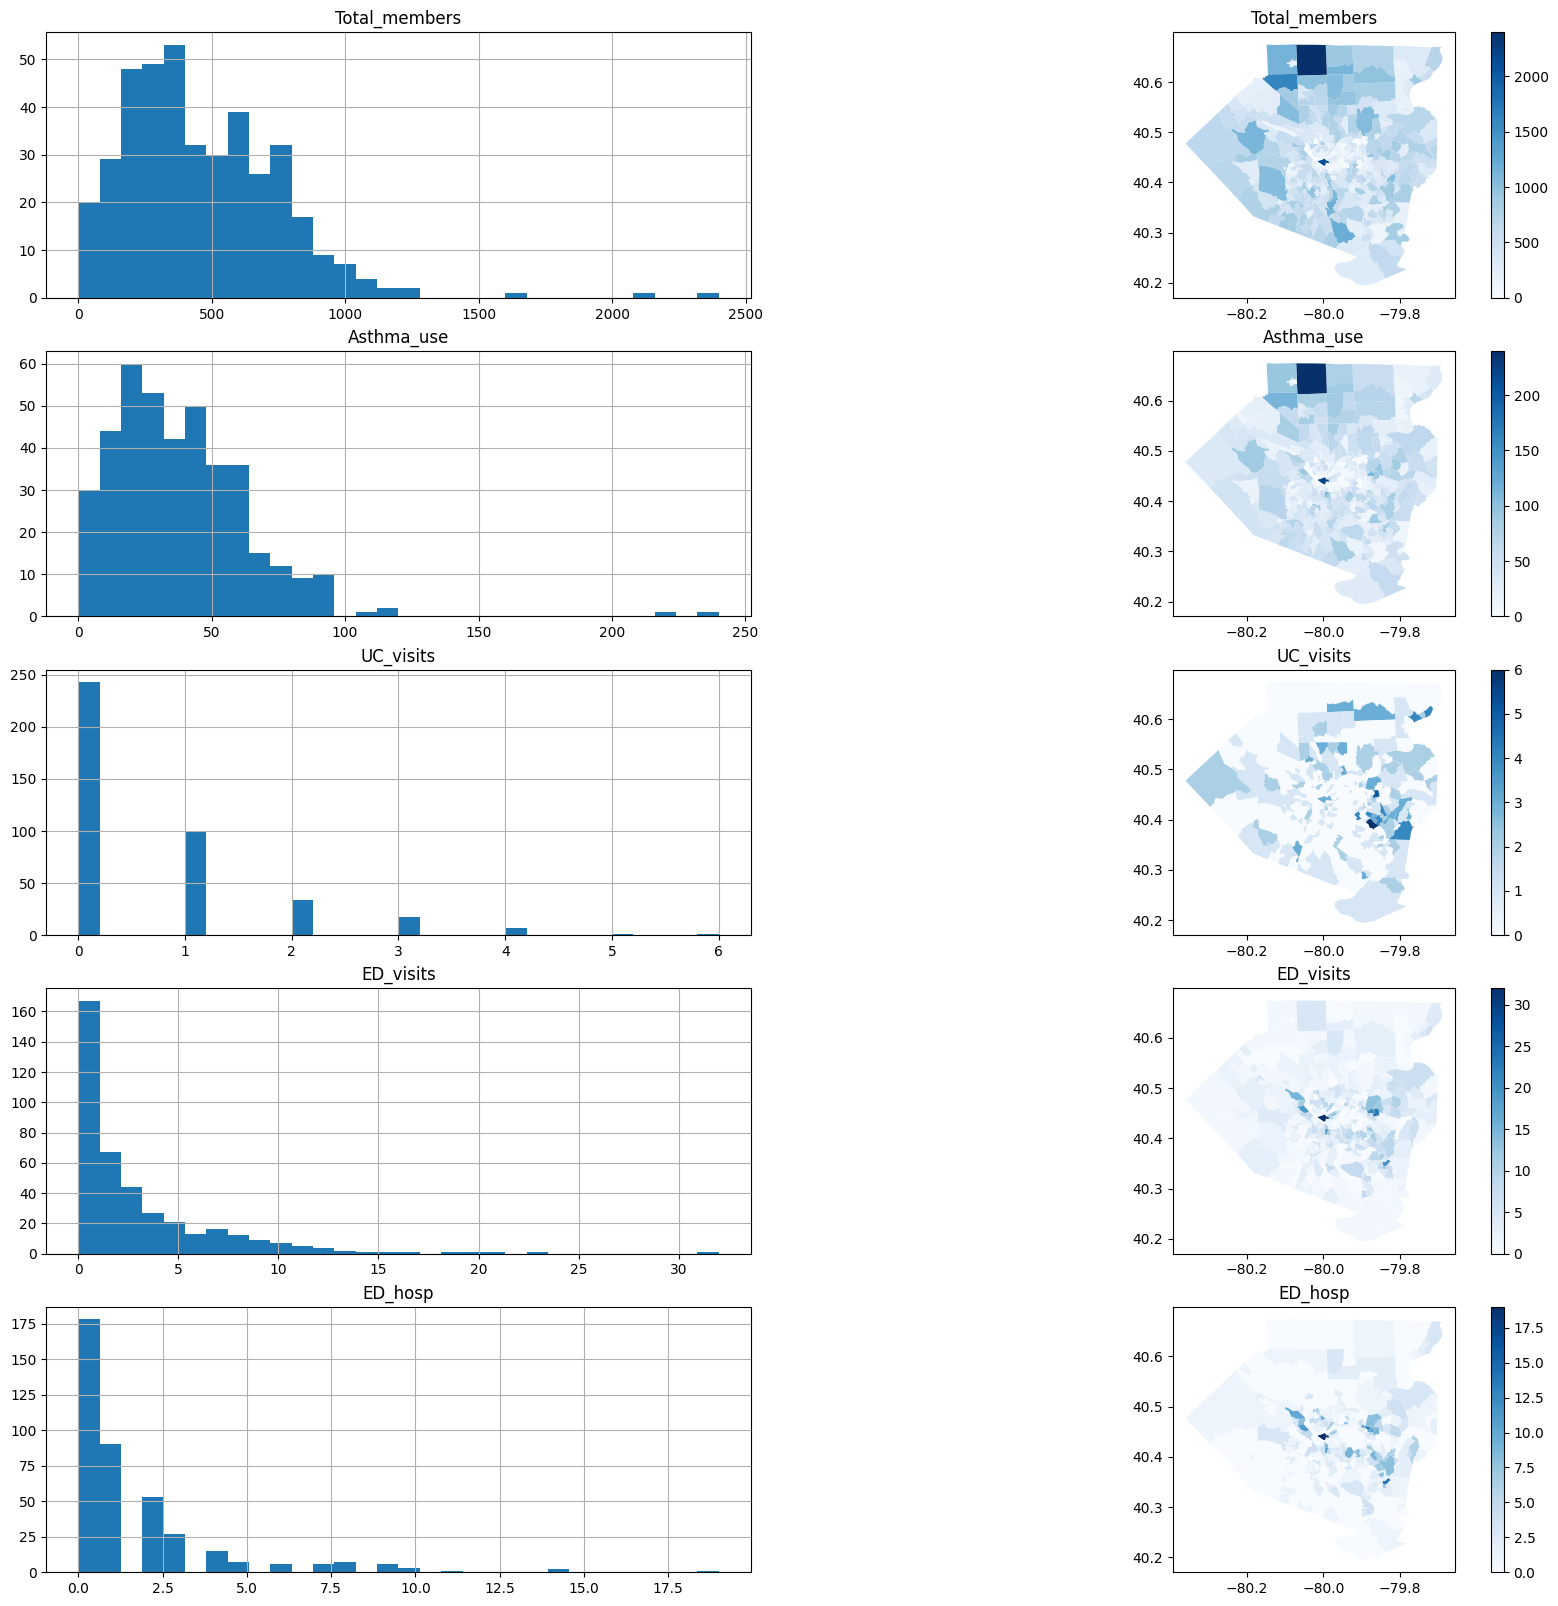

In [5]:
# what's the distribution of the raw variables?
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
row = 0
for var in ["Total_members", "Asthma_use", "UC_visits", "ED_visits", "ED_hosp"]:
    asthma[var].hist(bins=30, ax=axs[row,0])
    axs[row,0].set_title(var)
    asthma.plot(column=var, cmap="Blues", legend=True, ax=axs[row,1])
    axs[row,1].set_title(var)
    row += 1

There is large variability in the number of potential children with asthma-related medical encounters. I will not be analyzing the raw counts, instead I will compute fractions of children with at least one encounter.

The maximum number of children with at least one urgent care encounter is far less than those with an ED visit, or even with an ED hospitalization. This is not what I would initially expect, since I would assume that
- an ED visit (and especially an ED hospitalization) would be for more severe symptoms than an urgent care visit
- the more severe a symptom, the less common its occurence

This result may reflect more about patterns of health care system use than it does about severity of asthma symptoms. For example, some families may delay seeking medical attention until symptoms are extremely severe and emergency care is needed. Other families may lack access to primary care or urgent care, and seek ED treatment for all medical needs. Both of these cases would increase the number of ED visits while decreasing urgent care visits.

## Compute derived variables

In [6]:
# convert all counts to fractions of potential patients
# if no members in census tract, fill with 0
for col in ["Asthma_use", "UC_visits", "ED_visits", "ED_hosp"]:
    asthma["{}_frac".format(col)] = (asthma[col] / asthma.Total_members).fillna(0)
# of children with any asthma related encounter, how many had an emergency/urgent visit?
# if no asthma related encounter, fill with 0
for col in ["UC_visits", "ED_visits", "ED_hosp"]:
    asthma["{}_usefrac".format(col)] = (asthma[col] / asthma.Asthma_use).fillna(0)
# of children with an asthma related ED visit, how many were hospitalized?
# if no asthma related ED visit, fill with 0
asthma["ED_hosp_visitfrac"] = (asthma.ED_hosp / asthma.ED_visits).fillna(0)

comp_vars = ["Asthma_use_frac", "UC_visits_frac", "ED_visits_frac", "ED_hosp_frac",
             #"UC_visits_usefrac", "ED_visits_usefrac", "ED_hosp_usefrac", 
             #"ED_hosp_visitfrac",
            ]

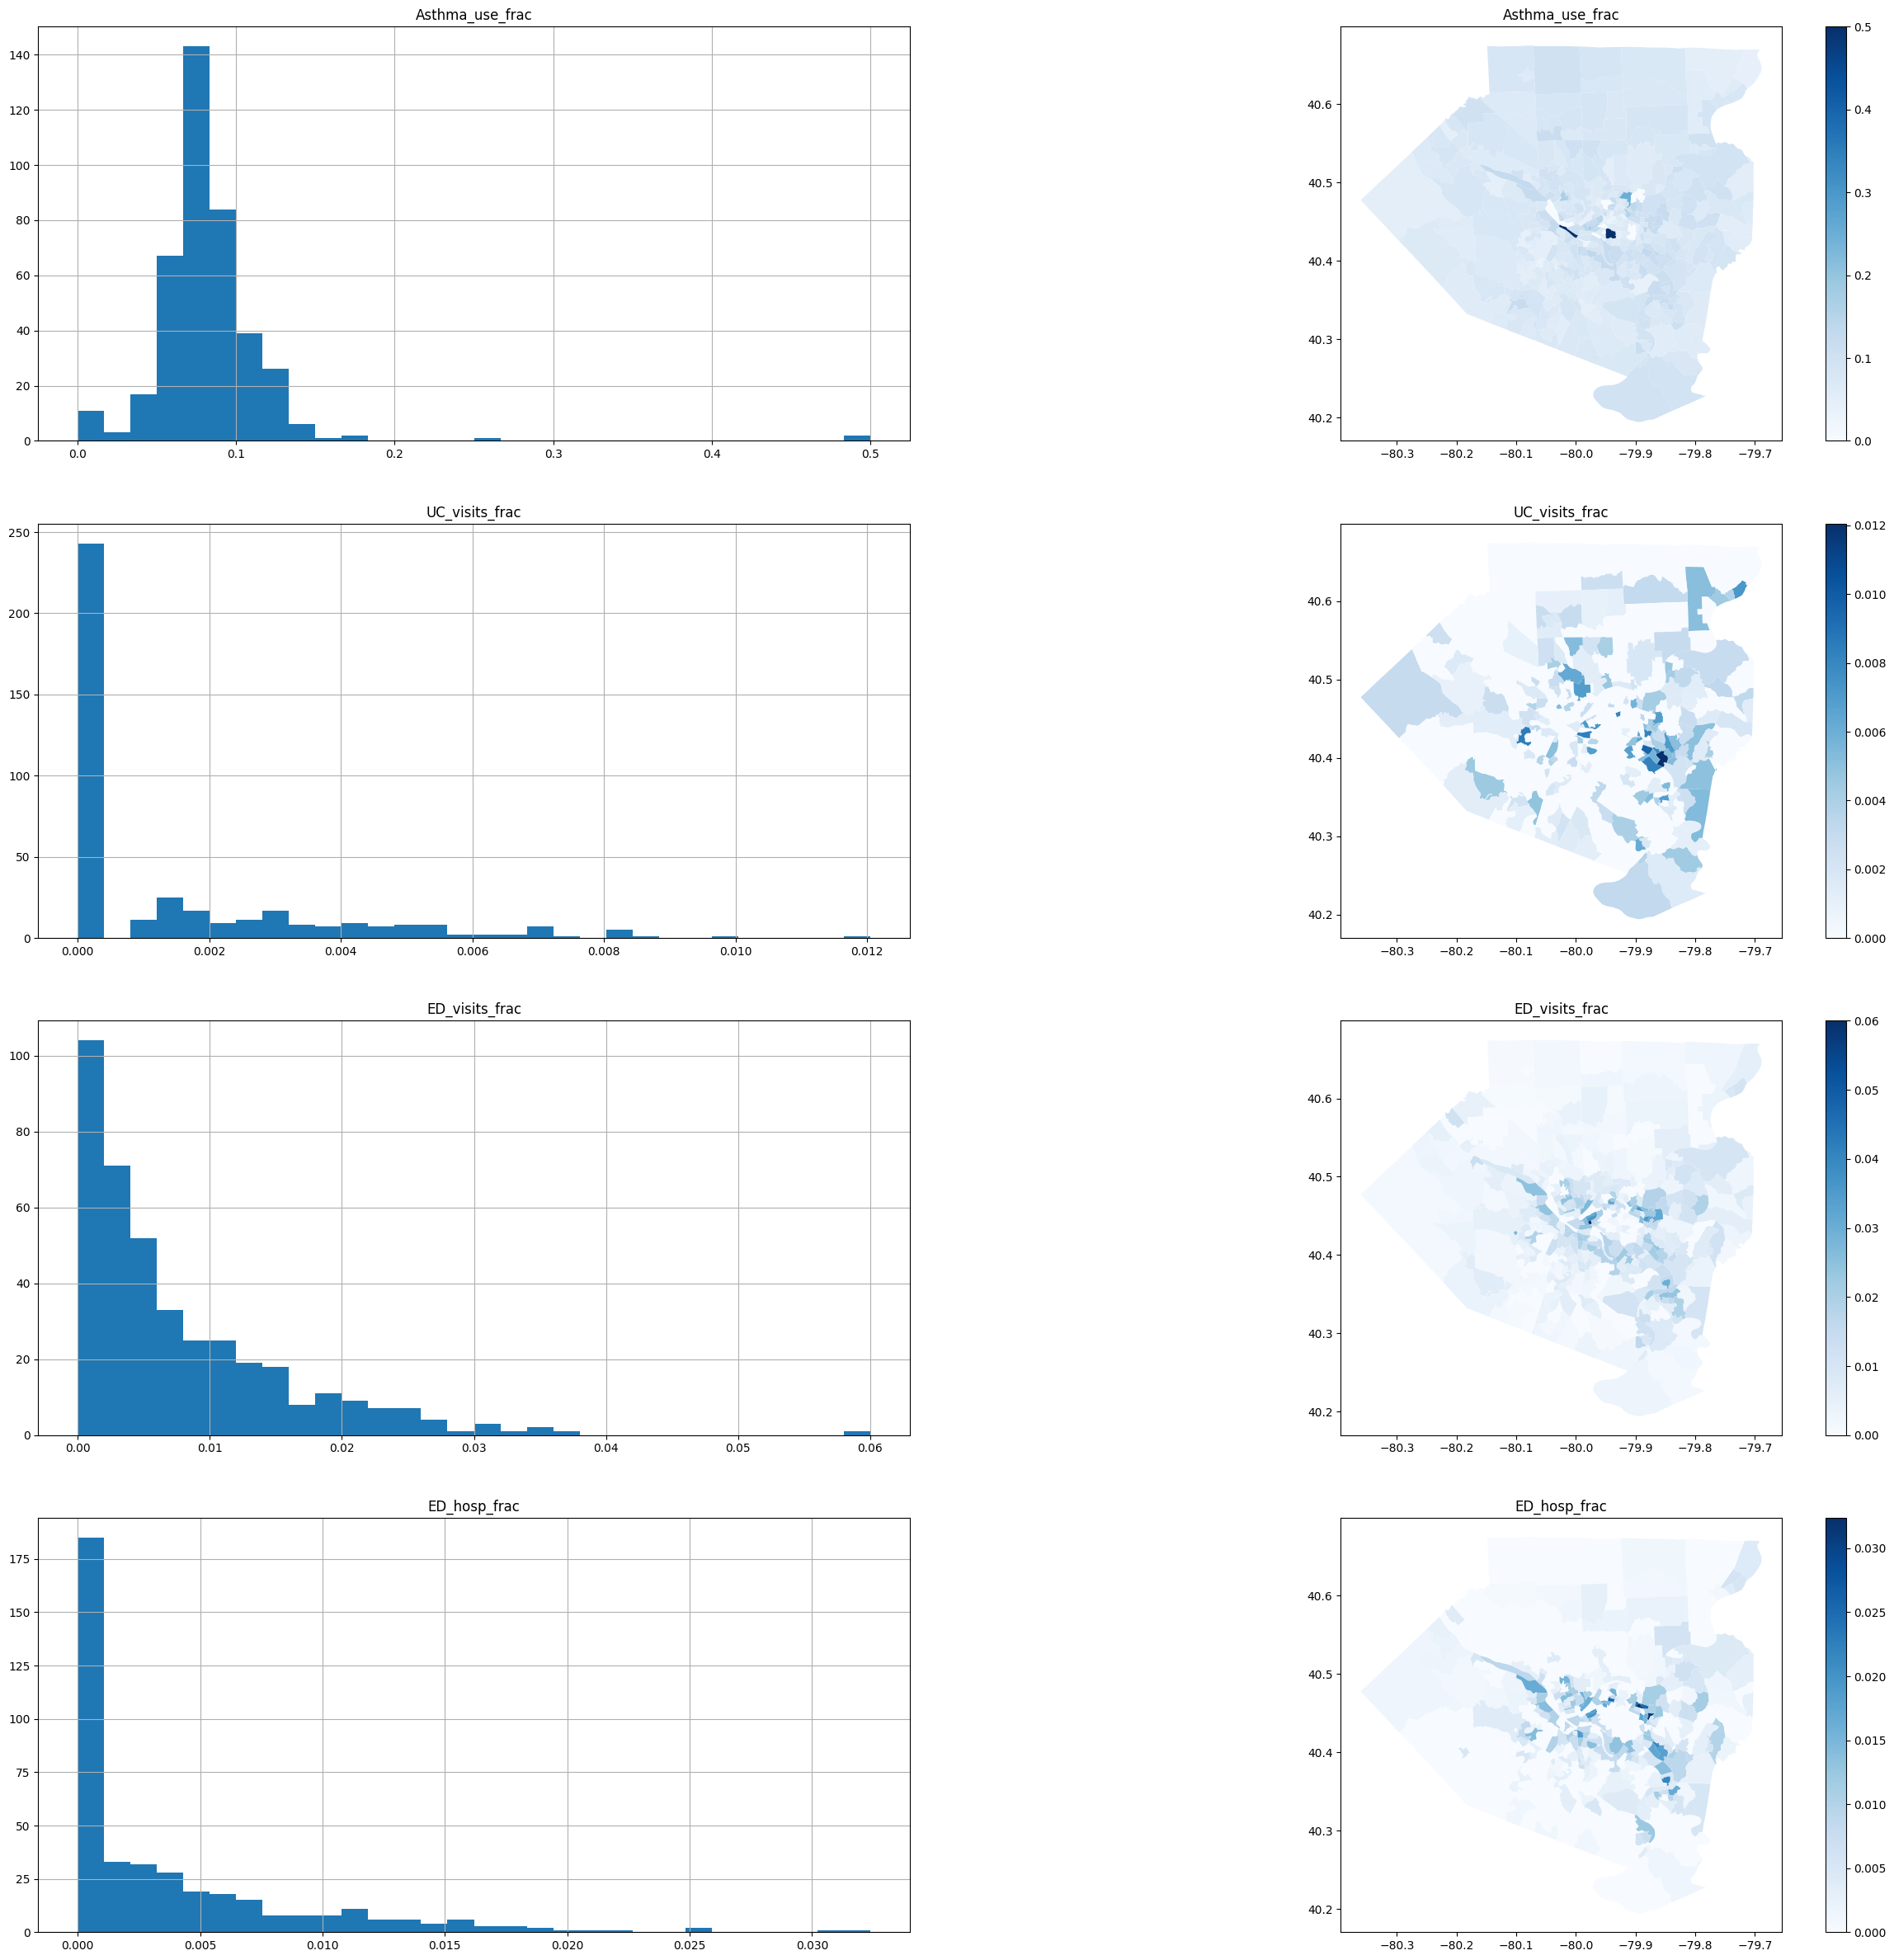

In [7]:
# what's the distribution of the derived variables?
fig, axs = plt.subplots(len(comp_vars), 2, figsize=(30, 30))
row = 0
for var in comp_vars:
    asthma[var].hist(bins=30, ax=axs[row,0])
    axs[row,0].set_title(var)
    asthma.plot(column=var, cmap="Blues", legend=True, ax=axs[row,1])
    axs[row,1].set_title(var)
    row += 1

### Outliers in overall asthma-related encounters
There are apparent outlier `Asthma_use_frac` among the census tracts, where  `Asthma_use_frac` > 0.2. Are there other variables/tracts flagged by a statistical test for outliers?

In [8]:
# use Tukey's ("far out") fence to flag outliers systematically
for dep_var in comp_vars:
    Q1 = np.percentile(asthma[dep_var], 25, method='midpoint')
    Q3 = np.percentile(asthma[dep_var], 75, method='midpoint')
    IQR = Q3 - Q1
    ub = Q3 + 3*IQR
    lb = Q1 - 3*IQR
    print(asthma.loc[(asthma[dep_var] > ub) | (asthma[dep_var] < lb)][["GEOID10", "Total_members", dep_var]])

         GEOID10  Total_members  Asthma_use_frac
13   42003051100          150.0             0.18
389  42003980100            4.0             0.25
392  42003980500            4.0             0.50
394  42003980700            2.0             0.50
         GEOID10  Total_members  UC_visits_frac
306  42003512800          332.0        0.012048
309  42003514000          415.0        0.009639
        GEOID10  Total_members  ED_visits_frac
13  42003051100          150.0            0.06
         GEOID10  Total_members  ED_hosp_frac
33   42003101700          315.0      0.025397
44   42003130100          553.0      0.025316
45   42003130200          278.0      0.032374
362  42003561100          224.0      0.031250


In [9]:
# what's happening in the census tracts with Asthma_use_frac > 0.2?
asthma.loc[asthma.Asthma_use_frac > 0.2][["Census_tract", "Total_members", "Asthma_use", "UC_visits", "ED_visits", "Asthma_use_frac"]]

,Census_tract,Total_members,Asthma_use,UC_visits,ED_visits,Asthma_use_frac
389,4.200398e+10,4.0,1.0,0.0,0.0,0.25
392,4.200398e+10,4.0,2.0,0.0,0.0,0.50
394,4.200398e+10,2.0,1.0,0.0,0.0,0.50


In [10]:
# how many census tracts have so few members?
asthma.loc[asthma.Total_members <= 4][["GEOID10", "Total_members", "Asthma_use"]]

,GEOID10,Total_members,Asthma_use
388,42003980000,1.0,0.0
389,42003980100,4.0,1.0
390,42003980300,4.0,0.0
392,42003980500,4.0,2.0
394,42003980700,2.0,1.0
395,42003980800,0.0,0.0
396,42003980900,0.0,0.0
398,42003981100,0.0,0.0
399,42003981200,0.0,0.0


The outlier `Asthma_use_frac` values occur in census tracks with very small total members, so each child with an asthma-related encounter has an outsized impact on the fraction of children. The values for these tracts may be accurate, but they are not representative.

For the other outliers flagged by IQR, I do not consider these values sufficiently disruptive to remove.

## Handle outliers and missing data

I am going to handle the outliers in `Asthma_use_frac` and the overall missing data in the same way. For the outliers, I am essentially saying that there are so few potential children with asthma in those census tracts that it is reasonable to treat them as if there are none.

The most straightforward way to impute missing data is using the median, since this value is unlikely to disturb analyses later on. However, in this case I am imputing a value of the *dependent* variable (we will be attempting to predict childhood asthma using air quality). Imputing a dependent variable doesn't usually make sense, you would just not make a prediction, and not worry about missing data. I'm still not worried about missing data, but I want to explain exactly why I might be.

My hypothesis is that air quality, a variable I expect to be spatially autocorrelated, is predictive of asthma. Therefore, I also suspect that asthma is spatially autocorrelated, and I will need to take that into account. The methods of handling spatial autocorrelation rely on using spatial lag weights to summarize how spatially related two census tracts are. I can define spatial lag weights either by
- a contiguity measure
    - there will be holes in the map where data is missing, which is fine, since those tracts can't possibly be correlated with any other tracts
- a distance based measure

In [11]:
# remove census tracts without data and with insufficient Total_members
asthma = asthma.loc[asthma.Total_members > 4]

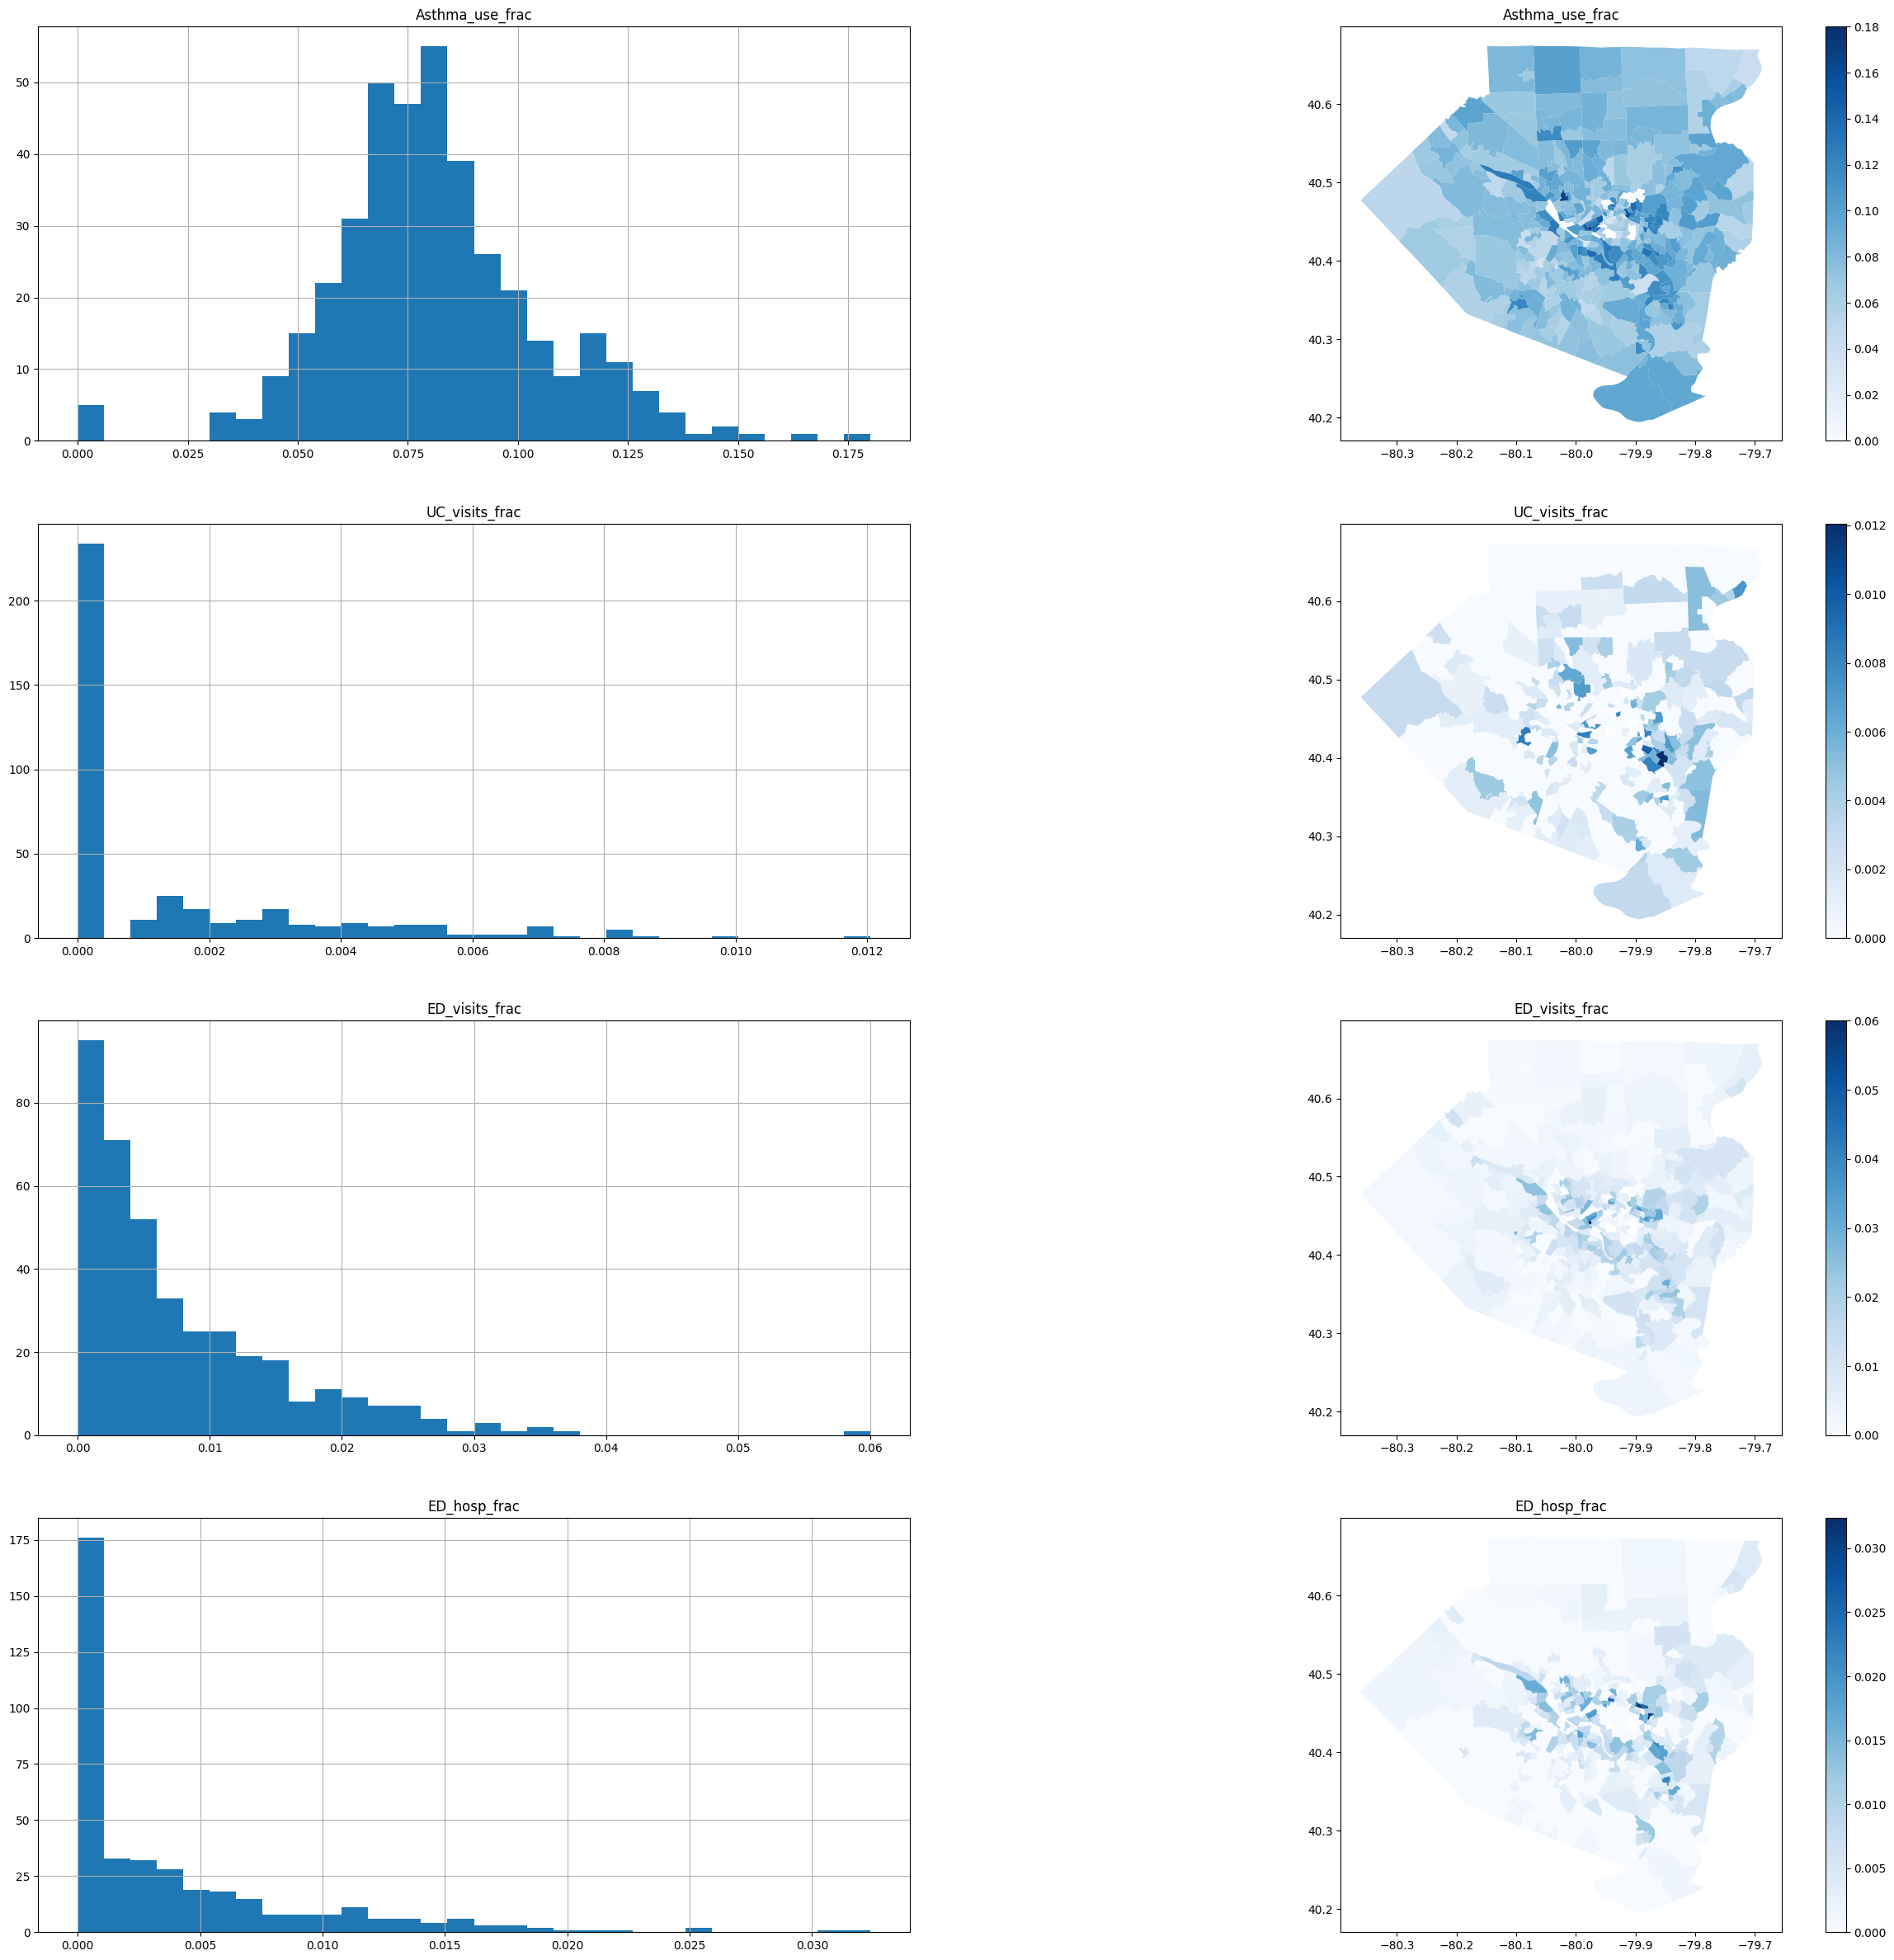

In [12]:
# re-check distribution with outliers/missing data removed
fig, axs = plt.subplots(len(comp_vars), 2, figsize=(30, 30))
row = 0
for var in comp_vars:
    asthma[var].hist(bins=30, ax=axs[row,0])
    axs[row,0].set_title(var)
    asthma.plot(column=var, cmap="Blues", legend=True, ax=axs[row,1])
    axs[row,1].set_title(var)
    row += 1

In [ ]:
# TODO save as pre-processed data